In [3]:
from utils import *
import numpy as np
from numpy.random import seed
import tensorflow as tf
import datetime
import pandas as pd 

# Custom imports
from nets import unet, unet_2d, unet_bi, unetpp, unetpp_2d, scSEunet, scSEunetpp
from config import get_config

cfg = get_config()

X,  Y, paths  = load_dataset('data_full/test/', return_paths=True, pad=28)
Xx, Y, paths  = load_dataset('data_full/test/', return_paths=True, addcoords=True, pad=28)

Using TensorFlow backend.
100%|██████████| 10/10 [00:01<00:00,  9.37it/s]


In [4]:
model = scSEunet(256, 256, 64, 1)
model.load_weights('models/256_model_scseunet2_fl.p5')

In [5]:
outs = model.predict(X, batch_size=1)

In [25]:
if type(outs) == type([]):
    outs = outs[-1]

export_outs(X, Y, outs, 'outs/global/', paths=paths)

def summary(outs, Y):
    tabledata = []
    means = [0] * 5
    for i in range(outs.shape[0]):
        row = [paths[i]]
        mean = 0
        for j in range(1, 6):
            yt = Y[i,:,:,:,j]
            yp = outs[i,:,:,:,j]

            dice = dice_coef(yt, yp, numpy=True) * 100
            row.append('%.2f' % dice)
            
            mean += (dice / 5)
            means[j-1] += (dice / outs.shape[0])

        row.append('%.2f' % mean)
        tabledata.append(row)
    tabledata.append(['Mean'] + ['%.2f' % m for m in means] + ['%.2f' % np.mean(means)])
    df = pd.DataFrame(tabledata, columns=['Name', 'Liver', 'Kidney', 'Stomach', 'Duodenum', 'Largebowel', 'Mean'])
    df = df.set_index('Name')
    return df

Exporting...


In [49]:
seg = ind2onehot(outs.argmax(axis=-1))

In [1]:
seg_global = outs.argmax(axis=-1)
seg_actual = Y.argmax(axis=-1)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(seg_global[9,:,:,slc])
plt.subplot(133)
plt.imshow(seg_actual[9,:,:,slc])

NameError: name 'outs' is not defined

In [2]:
summary(ind2onehot(seg_global), Y)

NameError: name 'summary' is not defined

# Local refinement

In [27]:
X = np.concatenate((Xx, outs), axis=4)
X.shape

(10, 256, 256, 64, 10)

In [37]:
output = np.zeros_like(outs)
output.shape

(10, 256, 256, 64, 6)

In [38]:
patch_model = unet(64, 64, 16, 10, bn=True)
patch_model.load_weights('models/model_1.unet_patches.p5')

In [39]:
steps = (32,32,8)

In [40]:
for i in range(0,256-64+1,steps[1]):
    for j in range(0,256-64+1,steps[0]):
        for k in range(0,64-16+1,steps[2]):
            iend = i+64
            jend = j+64
            kend = k+16
            patch = X[:,j:jend,i:iend,k:kend]
            out = patch_model(patch)
            output[:,j:jend,i:iend,k:kend] += out


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



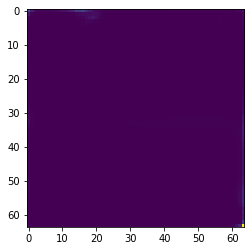

In [67]:
plt.imshow(out[6,:,:,7,2])

In [60]:
seg_local = output.argmax(axis=-1)
slc = 40

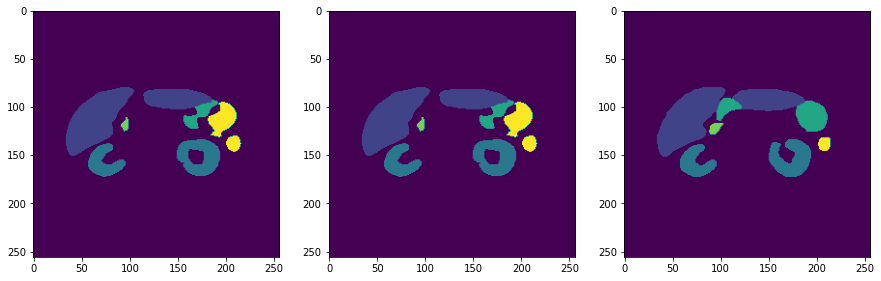

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(seg_local[9,:,:,slc])
plt.subplot(132)
plt.imshow(seg_global[9,:,:,slc])
plt.subplot(133)
plt.imshow(seg_actual[9,:,:,slc])

In [44]:
if type(output) == type([]):
    output = output[-1]

# export_outs(X, Y, output, 'outs/local/', paths=paths)

Exporting...


,Liver,Kidney,Stomach,Duodenum,Largebowel,Mean
Name,,,,,,
orig_data_111.mat,23.33,23.08,22.12,15.85,25.02,21.88
orig_data_112.mat,21.88,20.76,22.57,7.35,22.73,19.06
orig_data_113.mat,22.21,0.13,16.99,3.80,9.25,10.48
orig_data_114.mat,23.35,20.39,23.22,26.27,24.48,23.54
orig_data_115.mat,22.35,22.10,24.04,19.89,28.31,23.34
orig_data_116.mat,22.19,13.44,22.41,22.62,26.93,21.52
orig_data_117.mat,22.31,22.38,18.11,22.69,22.90,21.68
orig_data_118.mat,22.67,22.85,23.66,13.41,24.79,21.48
orig_data_119.mat,22.83,22.51,23.11,16.02,21.96,21.29


249434780

In [48]:
seg = ind2onehot(output.argmax(axis=-1))
summary(seg, output)


,Liver,Kidney,Stomach,Duodenum,Largebowel,Mean
Name,,,,,,
orig_data_111.mat,22.68,23.58,22.97,19.06,23.64,22.39
orig_data_112.mat,23.24,22.95,23.60,21.09,26.99,23.57
orig_data_113.mat,23.07,24.31,23.39,23.16,25.90,23.97
orig_data_114.mat,23.74,22.63,24.61,17.96,24.84,22.76
orig_data_115.mat,22.94,23.56,23.55,24.12,25.05,23.85
orig_data_116.mat,22.63,25.76,23.79,24.07,26.12,24.48
orig_data_117.mat,23.07,22.71,24.02,19.92,24.65,22.87
orig_data_118.mat,23.59,22.61,23.53,24.97,25.43,24.03
orig_data_119.mat,24.01,22.95,23.86,25.90,24.98,24.34
